<a href="https://colab.research.google.com/github/uginm102/MCSC-MUK/blob/main/MCS%207224%20Computer%20Vision/Assignment%203/MCS_7224_Computer_Vision_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.feature import hog
from skimage import exposure
from skimage.feature import local_binary_pattern
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


try:
  import mahotas
except:
  !pip install mahotas
  import mahotas

try:
  from tensorflow.keras.applications import VGG16
  from tensorflow.keras.layers import GlobalAveragePooling2D
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
  from tensorflow.keras.preprocessing.image import load_img, img_to_array
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from tensorflow.keras.applications import ResNet50
except:
  !pip install tensorflow
  from tensorflow.keras.applications import VGG16
  from tensorflow.keras.layers import GlobalAveragePooling2D
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
  from tensorflow.keras.preprocessing.image import load_img, img_to_array
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from tensorflow.keras.applications import ResNet50


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
diseased_images = glob('/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/model/images/train/Diseased/*.jpg')
healthy_images = glob('/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/model/images/train/Healthy/*.jpg')
print(f"Diseased: {len(diseased_images)}, Healthy: {len(diseased_images)}")

Diseased: 22, Healthy: 22


In [ ]:
image_path = "/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/images/Leafspot Scale 1/DSC06395.JPG"

image = cv2.imread(image_path)


print('Image Dimensions:', image.shape)



Image Dimensions: (4000, 6000, 3)


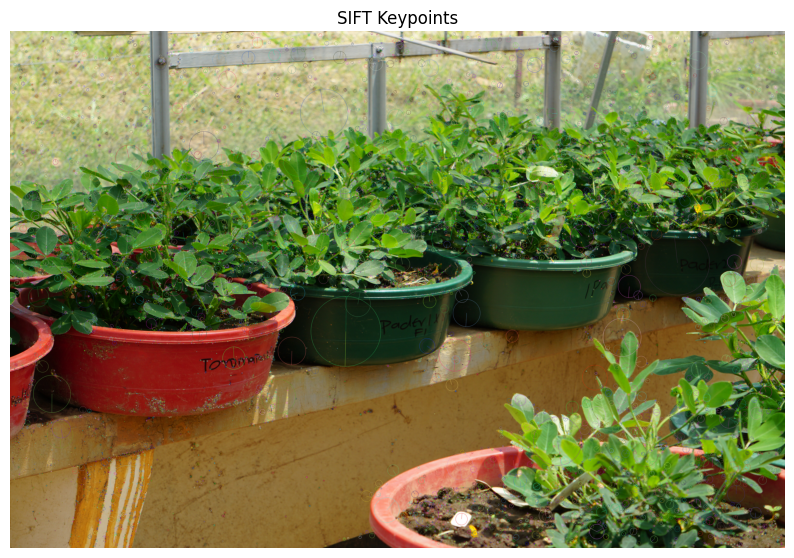

Number of keypoints detected: 19058


In [ ]:
# Step 2: Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Initialize the SIFT detector
sift = cv2.SIFT_create()

# Step 4: Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Step 5: Draw the keypoints on the original image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Step 6: Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()
# Step 7: Print the number of keypoints detected
print(f'Number of keypoints detected: {len(keypoints)}')

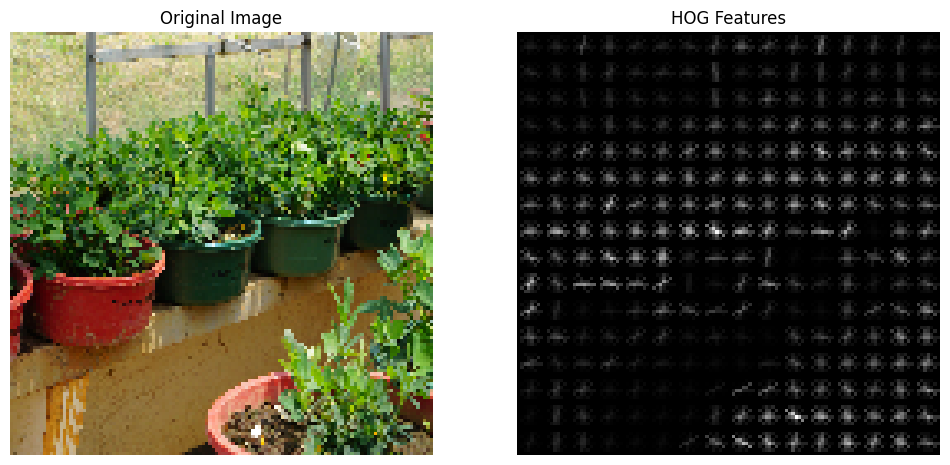

Shape of HOG features: (8100,)
Total number of HOG features: 8100


In [ ]:
gray_image_resized = cv2.resize(gray_image, (128, 128))

# Step 4: Compute HOG features
hog_features, hog_image = hog(
    gray_image_resized,
    orientations=9,           # Number of orientation bins
    pixels_per_cell=(8, 8),   # Size of each cell
    cells_per_block=(2, 2),   # Number of cells in each block
    visualize=True,           # Return HOG image for visualization
    transform_sqrt=True       # Apply power law compression to normalize
)

# Step 5: Enhance the HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Step 6: Display the original image and HOG image
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.resize(image, (128, 128)), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# HOG image
plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Features')
plt.axis('off')

plt.show()

# Step 7: Print the shape of the HOG features
print(f'Shape of HOG features: {hog_features.shape}')
print(f'Total number of HOG features: {hog_features.size}')

Local Binary Patterns (LBP)

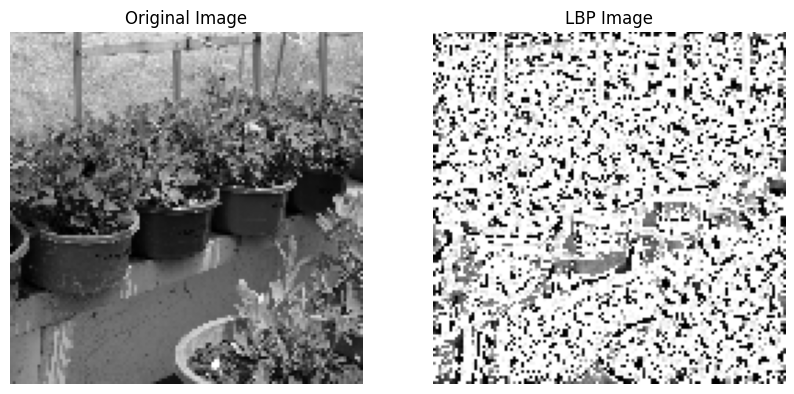

LBP Feature Histogram Shape: (26,)


In [ ]:
image_lbp = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
image_lbp = cv2.resize(image_lbp, (128, 128))  # Resize for consistency

# Compute LBP
radius = 3
n_points = 8 * radius  # Number of points in the circular neighborhood
lbp = local_binary_pattern(image_lbp, n_points, radius, method='uniform')

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_lbp, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Image')
plt.axis('off')

plt.show()

# Extract histogram of LBP for feature representation
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
print(f'LBP Feature Histogram Shape: {hist.shape}')

Color Histograms

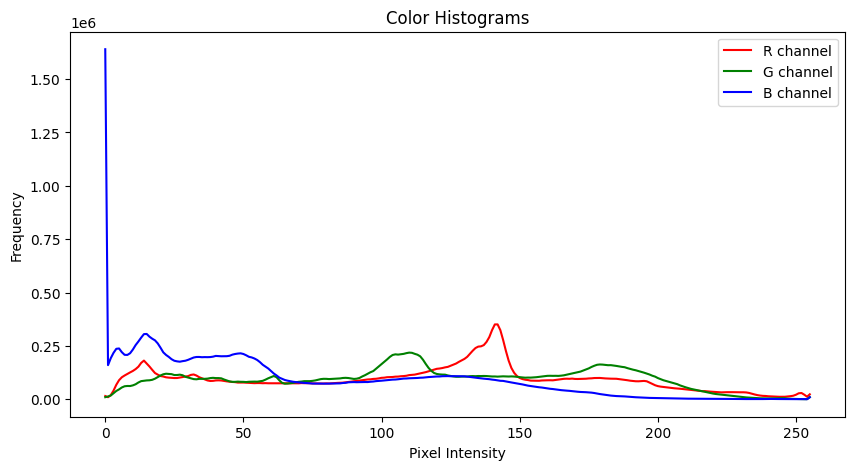

Feature size per channel: 256


In [ ]:
image_ch = cv2.imread(image_path)
image_ch = cv2.cvtColor(image_ch, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Compute histograms for each channel
colors = ('r', 'g', 'b')
histograms = []
for i, color in enumerate(colors):
    hist = cv2.calcHist([image_ch], [i], None, [256], [0, 256])
    histograms.append(hist)

# Plot histograms
plt.figure(figsize=(10, 5))
for i, (hist, color) in enumerate(zip(histograms, colors)):
    plt.plot(hist, color=color, label=f'{color.upper()} channel')
plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print feature size
print(f'Feature size per channel: {histograms[0].size}')

Edge Detection (Canny)

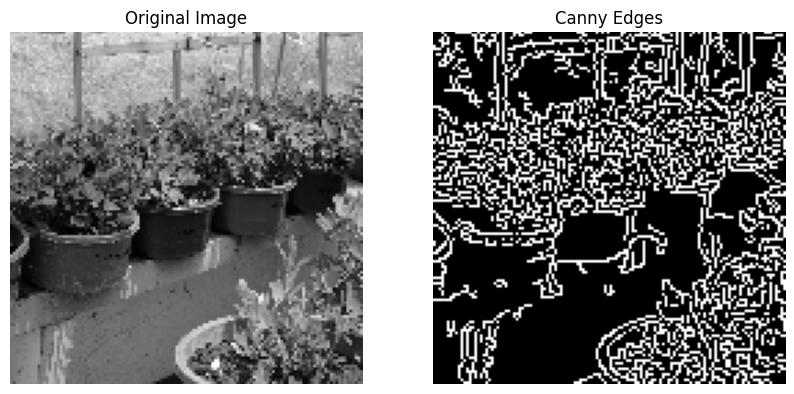

Number of edge pixels: 4285


In [ ]:
image_ed = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_ed = cv2.resize(image_ed, (128, 128))

# Apply Canny edge detection
edges = cv2.Canny(image_ed, 100, 200)  # Thresholds for hysteresis

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_ed, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()

# Feature representation (e.g., edge pixel count)
edge_count = np.sum(edges > 0)
print(f'Number of edge pixels: {edge_count}')

Haralick Texture Features

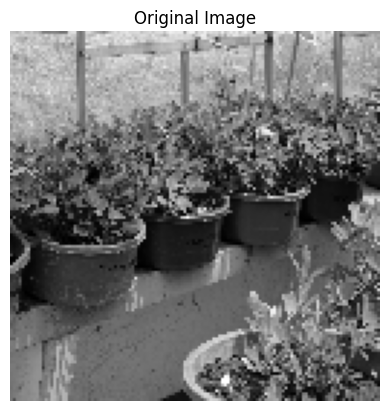

Contrast: 0.0001
Correlation: 1472.2559
Variance: 0.7524
Inverse Diff Moment: 2973.9442
Sum Average: 0.0954
Sum Variance: 217.3505
Sum Entropy: 10423.5208
Entropy: 8.5775
Diff Variance: 13.5414
Diff Entropy: 0.0001
Info Measure 1: 6.0103
Info Measure 2: -0.2323
Max Corr Coeff: 0.9855


In [ ]:
image_htf = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_htf = cv2.resize(image_htf, (128, 128))

# Compute Haralick features
features = mahotas.features.haralick(image_htf).mean(axis=0)

# Visualize the original image
plt.imshow(image_htf, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Print features (13 Haralick descriptors)
feature_names = ['Contrast', 'Correlation', 'Variance', 'Inverse Diff Moment',
                 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy',
                 'Diff Variance', 'Diff Entropy', 'Info Measure 1', 'Info Measure 2', 'Max Corr Coeff']
for name, value in zip(feature_names, features):
    print(f'{name}: {value:.4f}')

Convolutional Neural Networks (CNNs) - VGG16

In [ ]:
image_cnn = load_img(image_path, target_size=(224, 224))  # VGG16 expects 224x224
image_cnn = img_to_array(image_cnn)
image_cnn = np.expand_dims(image_cnn, axis=0)  # Add batch dimension
image_cnn = tf.keras.applications.vgg16.preprocess_input(image_cnn)

# Load pre-trained VGG16 model (without top layer for feature extraction)
model_vgg16 = VGG16(weights='imagenet', include_top=False)

# Extract features
features = model_vgg16.predict(image_cnn)

# Print feature shape
print(f'VGG16 Feature Shape: {features.shape}')  # e.g., (1, 7, 7, 512)

# Flatten features for downstream use
flat_features = features.flatten()
print(f'Flattened Feature Size: {flat_features.size}')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
VGG16 Feature Shape: (1, 7, 7, 512)
Flattened Feature Size: 25088


Autoencoders

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


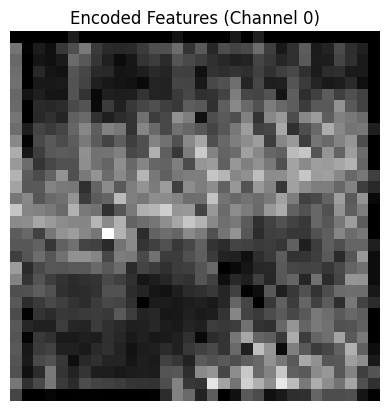

Feature Shape: (1, 32, 32, 8)


In [ ]:
image_auto = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64), color_mode='grayscale')
image_auto = tf.keras.preprocessing.image.img_to_array(image_auto) / 255.0
images_auto = np.expand_dims(image_auto, axis=0)  # Batch of 1 image

# Build autoencoder
input_img = layers.Input(shape=(64, 64, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)  # Encoded representation
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train (single image for demo; use larger dataset in practice)
autoencoder.fit(images_auto, images_auto, epochs=50, batch_size=1, verbose=0)

# Extract features from encoder
encoder = models.Model(input_img, encoded)
features = encoder.predict(images_auto)

# Visualize
plt.imshow(features[0, :, :, 0], cmap='gray')
plt.title('Encoded Features (Channel 0)')
plt.axis('off')
plt.show()

print(f'Feature Shape: {features.shape}')

Transfer Learning - ResNet50

In [ ]:
image_resnet = load_img(image_path, target_size=(224, 224))  # ResNet50 expects 224x224
image_resnet = img_to_array(image_resnet)
image_resnet = np.expand_dims(image_resnet, axis=0)  # Add batch dimension
image_resnet = tf.keras.applications.resnet50.preprocess_input(image_resnet)

# Load pre-trained ResNet50 model (without top layer)
model = ResNet50(weights='imagenet', include_top=False)

# Extract features
features = model.predict(image_resnet)

# Print feature shape
print(f'ResNet50 Feature Shape: {features.shape}')  # e.g., (1, 7, 7, 2048)

# Flatten features
flat_features = features.flatten()
print(f'Flattened Feature Size: {flat_features.size}')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
ResNet50 Feature Shape: (1, 7, 7, 2048)
Flattened Feature Size: 100352


In [18]:
# Step 1: Synthetic Dataset Preparation (Replace with your real dataset)
def load_and_extract_hog(image_path, label, size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
    return hog_features, label

# Example: Replace with paths to your images
image_paths = [
    ('path/to/cat1.jpg', 0), ('path/to/cat2.jpg', 0), ('path/to/dog1.jpg', 1), ('path/to/dog2.jpg', 1)
]  # Add more paths as needed Healthy
features, labels = [], []
for path in diseased_images:
  label = "Diseased"
  feat, lbl = load_and_extract_hog(path, label)
  features.append(feat)
  labels.append(lbl)

for path in healthy_images:
  label = "Healthy"
  feat, lbl = load_and_extract_hog(path, label)
  features.append(feat)
  labels.append(lbl)

X = np.array(features)
y = np.array(labels)

# Step 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define and Train Models
models = {
    'SVM': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))



SVM Accuracy: 0.6364
              precision    recall  f1-score   support

    Diseased       0.00      0.00      0.00         4
     Healthy       0.64      1.00      0.78         7

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Accuracy: 0.7273
              precision    recall  f1-score   support

    Diseased       1.00      0.25      0.40         4
     Healthy       0.70      1.00      0.82         7

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11

KNN Accuracy: 0.5455
              precision    recall  f1-score   support

    Diseased       0.43      0.75      0.55         4
     Healthy       0.75      0.43      0.55         7

    accuracy                           0.55        11
   macro avg       0.59      0.59      0.55        11
weighted avg       0.63      0.55      0.55        11

AdaBoost Accuracy: 0.5455
              precision    recall  f1-score   support

    Diseased       0.33      0.25      0.29         4
     Healthy       0.62      0.71      0.67         7

    accuracy                           0.55        11
   macro avg       0.48      0.48      0.48       

In [25]:
# Step 4: Custom CNN (requires reshaping features if using HOG directly isn’t suitable)
# For CNN, we typically use raw images, not HOG features. Here's an alternative with images:
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path  in diseased_images + healthy_images]
images = [cv2.resize(img, (128, 128)) for img in images]
X_images = np.array(images).reshape(-1, 128, 128, 1) / 255.0  # Normalize
# print(X_images)
# y_images = y
# Convert labels to numerical representation (0 for 'Diseased', 1 for 'Healthy')
y_images = np.where(y == 'Diseased', 0, 1)

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_images, y_images, test_size=0.2, random_state=42)

cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_img, y_train_img, epochs=10, batch_size=2, validation_data=(X_test_img, y_test_img), verbose=1)
cnn_loss, cnn_acc = cnn.evaluate(X_test_img, y_test_img)
results['CNN'] = cnn_acc
print(f'CNN Accuracy: {cnn_acc:.4f}')

# Step 5: VGG16 as a Classifier (using pre-trained features)


# Load images for VGG16 (RGB, 224x224)
vgg_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in diseased_images + healthy_images]
vgg_images = [cv2.resize(img, (224, 224)) for img in vgg_images]
X_vgg = np.array(vgg_images)
X_vgg = tf.keras.applications.vgg16.preprocess_input(X_vgg)
# y_vgg = y
y_vgg = np.where(y == 'Diseased', 0, 1)

X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg, test_size=0.2, random_state=42)

base_model = VGG16(weights='imagenet', include_top=False)
vgg_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
base_model.trainable = False  # Freeze base layers
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.fit(X_train_vgg, y_train_vgg, epochs=5, batch_size=2, validation_data=(X_test_vgg, y_test_vgg), verbose=1)
vgg_loss, vgg_acc = vgg_model.evaluate(X_test_vgg, y_test_vgg)
results['VGG16'] = vgg_acc
print(f'VGG16 Accuracy: {vgg_acc:.4f}')



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.3908 - loss: 0.7425 - val_accuracy: 0.6364 - val_loss: 0.6913
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8408 - loss: 0.6537 - val_accuracy: 0.6364 - val_loss: 0.6380
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8212 - loss: 0.5475 - val_accuracy: 0.6364 - val_loss: 0.6296
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8842 - loss: 0.3420 - val_accuracy: 0.8182 - val_loss: 0.7806
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9464 - loss: 0.1773 - val_accuracy: 0.7273 - val_loss: 0.8091
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 1.0000 - loss: 0.0649 - val_accuracy: 0.7273 - val_loss: 0.7442
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 0.8182 - val_loss: 0.9540
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8182 - val_l

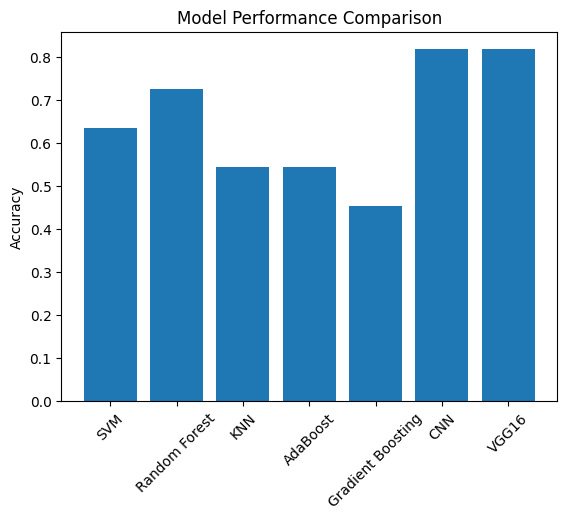

In [26]:
# Step 6: Analyze Results
plt.bar(results.keys(), results.values())
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()